# Validation Analysis

## Objective
Develop accuracy assessments for tree cover predictions in each country, region, subregion, ecoregion and biome to understand how the model performs differently in each class and determine where we need more data.  
Ultimately we want report that the error of the model at predicting tree cover was x +/- y at the 95% confidence level. 

How confident are we that a certain range around these estimates of tree cover actually contains the true parameter? In other words, what do the error bars look like for precision, recall and f1? How granular can we make these validation assessments for each region/subregion/ecoregion? 

**Steps**
- Bootstrap sample n times from each biome
- Calculate precision, recall and F1 scores for each bootstrap
- Calculate 75%, 95%, 99% confidence intervals for the samples
- Repeat for other categories and see what the error bars look like
- Create visualizations to see the error bars (bar chart and heatmap, examples [here?](https://clauswilke.com/dataviz/visualizing-uncertainty.html))


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

## Quick EDA

In [2]:
df = pd.read_csv('validation_data_1000.csv')

In [3]:
df.region.value_counts()

Africa      501
Americas    499
Name: region, dtype: int64

In [4]:
df.subregion.value_counts()

South America      321
Eastern Africa     180
Central America    144
Western Africa     110
Southern Africa     73
Northern Africa     71
Middle Africa       67
Caribbean           34
Name: subregion, dtype: int64

In [166]:
df.ecoregion.value_counts()[:10]

Sahelian Acacia Savanna                       64
West Sudanian Savanna                         51
Cerrado                                       42
Mediterranean Woodlands And Forests           24
Humid Pampas                                  21
Valdivian Temperate Forests                   21
Southern Miombo Woodlands                     18
Ethiopian Montane Grasslands And Woodlands    18
Central Zambezian Miombo Woodlands            17
Highveld Grasslands                           17
Name: ecoregion, dtype: int64

In [167]:
df.biome.value_counts()

Tropical and Subtropical Grasslands, Savannas and Shrublands    367
Tropical and Subtropical Moist Broadleaf Forests                246
Tropical and Subtropical Dry Broadleaf Forests                   97
Deserts and Xeric Shrublands                                     68
Montane Grasslands and Shrublands                                52
Mediterranean Forests, Woodlands and Scrub                       47
Temperate Grasslands, Savannas and Shrublands                    37
Tropical and Subtropical Coniferous Forests                      34
Temperate Broadleaf and Mixed Forests                            25
Flooded Grasslands and Savannas                                  22
Mangroves                                                         4
Name: biome, dtype: int64

In [168]:
df.tree_class.value_counts(normalize=True)*100

None (0%)                35.9
Scattered (1 - 9%)       21.6
Dense (75+%)             19.3
Open (10 - 39%)          16.5
Medium-dense (40-75%)     6.7
Name: tree_class, dtype: float64

In [169]:
df.isnull().sum()

field_1        0
plot_id        0
lat            0
long           0
error          0
abs_error      0
tp             0
fp             0
fn             0
tree_cover     0
tree_class     0
country        0
region         0
subregion      0
ecoregion     50
biome          1
dtype: int64

In [17]:
df[df.ecoregion.isnull()].tree_class.value_counts()

None (0%)                14
Scattered (1 - 9%)       12
Dense (75+%)             12
Open (10 - 39%)           8
Medium-dense (40-75%)     4
Name: tree_class, dtype: int64

In [252]:
len(df.country.unique())

72

In [253]:
len(df.ecoregion.unique())

164

In [193]:
df.biome.value_counts().reset_index().rename_axis('biomes')

,index,biome
biomes,,
0,"Tropical and Subtropical Grasslands, Savannas ...",367
1,Tropical and Subtropical Moist Broadleaf Forests,246
2,Tropical and Subtropical Dry Broadleaf Forests,97
3,Deserts and Xeric Shrublands,68
4,Montane Grasslands and Shrublands,52
5,"Mediterranean Forests, Woodlands and Scrub",47
6,"Temperate Grasslands, Savannas and Shrublands",37
7,Tropical and Subtropical Coniferous Forests,34
8,Temperate Broadleaf and Mixed Forests,25


In [198]:
sample_size = df.biome.value_counts().to_frame().reset_index()
sample_size.columns = ['category', 'num_samples']
sample_size

,category,num_samples
0,"Tropical and Subtropical Grasslands, Savannas ...",367
1,Tropical and Subtropical Moist Broadleaf Forests,246
2,Tropical and Subtropical Dry Broadleaf Forests,97
3,Deserts and Xeric Shrublands,68
4,Montane Grasslands and Shrublands,52
5,"Mediterranean Forests, Woodlands and Scrub",47
6,"Temperate Grasslands, Savannas and Shrublands",37
7,Tropical and Subtropical Coniferous Forests,34
8,Temperate Broadleaf and Mixed Forests,25
9,Flooded Grasslands and Savannas,22


## Bootstrap from each scale, calculate scores and confidence intervals

In [3]:
def bootstrap(df, scale, n):
    
    '''
    Function takes in a df, bootstraps n samples from each category in a column (scale) 
    and calculates the precision, recall and f1. Then takes percentiles of the bootstrap 
    to calculate confidence intervals. Returns separate dfs with the scores and CIs.
    '''
    
    # get a list of categories within the scale, dropping categories with less than 5 rows
    df = df.groupby(scale).filter(lambda x: len(x)>5)   
    categories = set(df[scale].dropna().unique())
    print(f'{scale} has {len(categories)} subcategories. {len(categories)*n} samples in total.')
    
                     
    # empty df to store samples, scores and CIs
    val_df = pd.DataFrame(columns = ['scale', 'category', 'precision', 'recall', 'f1'])
    conf_int = pd.DataFrame(columns = ['scale', 'category',
                                       'p_lower_95', 'p_upper_95', 'r_lower_95',
                                       'r_upper_95', 'f1_lower_95','f1_upper_95',
                                       'p_lower_90', 'p_upper_90', 'r_lower_90',
                                       'r_upper_90', 'f1_lower_90','f1_upper_90',
                                       'p_lower_80', 'p_upper_80', 'r_lower_80',
                                       'r_upper_80', 'f1_lower_80','f1_upper_80'])

    # calculation for precision, recall, f1
    def calculate_metrics(tp, fp, fn):
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = 2 * ((precision * recall) / (precision + recall))
        return precision, recall, f1
    
    # for each category in scale, calculate scores, 
    for i in categories:
        grouped = df[df[scale] == i]
        bootsamples = pd.DataFrame()
        
        for num in range(n):  
            bootstrap = grouped.sample(len(grouped), replace=True)
            bootsamples = bootsamples.append(bootstrap, ignore_index = True)
            precision, recall, f1 = calculate_metrics(sum(bootsamples.tp.values), 
                                                      sum(bootsamples.fp.values), 
                                                      sum(bootsamples.fn.values))
            
            # add calculations to empty df
            val_df = val_df.append({'scale': scale, 
                                   'category': i,
                                   'precision': precision,
                                   'recall': recall,
                                   'f1': f1}, ignore_index = True)
    
    # use scores in val_df to calculate CIs
    for i in categories:
        grouped2 = val_df[val_df.category == i] 

        # calculate 80, 90, 95th percentile
        p_lower_95, r_lower_95, f1_lower_95 = np.percentile(grouped2.precision.values, 2.5),\
                                              np.percentile(grouped2.recall.values, 2.5),\
                                              np.percentile(grouped2.f1.values, 2.5) 
        p_upper_95, r_upper_95, f1_upper_95 = np.percentile(grouped2.precision.values, 97.5),\
                                              np.percentile(grouped2.recall.values, 97.5),\
                                              np.percentile(grouped2.f1.values, 97.5)
                

        p_lower_90, r_lower_90, f1_lower_90 = np.percentile(grouped2.precision.values, 5),\
                                              np.percentile(grouped2.recall.values, 5),\
                                              np.percentile(grouped2.f1.values, 5) 
        p_upper_90, r_upper_90, f1_upper_90 = np.percentile(grouped2.precision.values, 95),\
                                              np.percentile(grouped2.recall.values, 95),\
                                              np.percentile(grouped2.f1.values, 95)
        

        p_lower_80, r_lower_80, f1_lower_80 = np.percentile(grouped2.precision.values, 10),\
                                              np.percentile(grouped2.recall.values, 10),\
                                              np.percentile(grouped2.f1.values, 10) 
        p_upper_80, r_upper_80, f1_upper_80 = np.percentile(grouped2.precision.values, 90),\
                                              np.percentile(grouped2.recall.values, 90),\
                                              np.percentile(grouped2.f1.values, 90)
        
        
        # add percentiles to empty df
        conf_int = conf_int.append({'scale': scale, 
                                    'category': i,
                                   'p_lower_95': p_lower_95, 
                                   'p_upper_95': p_upper_95, 
                                   'r_lower_95': r_lower_95,
                                   'r_upper_95': r_upper_95, 
                                   'f1_lower_95': f1_lower_95,
                                   'f1_upper_95': f1_upper_95,
                                   'p_lower_90': p_lower_90, 
                                   'p_upper_90': p_upper_90, 
                                   'r_lower_90': r_lower_90,
                                   'r_upper_90': r_upper_90, 
                                   'f1_lower_90': f1_lower_90,
                                   'f1_upper_90': f1_upper_90,
                                   'p_lower_80': p_lower_80, 
                                   'p_upper_80': p_upper_80, 
                                   'r_lower_80': r_lower_80,
                                   'r_upper_80': r_upper_80, 
                                   'f1_lower_80': f1_lower_80,
                                   'f1_upper_80': f1_upper_80}, ignore_index = True)
        
    # add columns with the mean precision, recall and f1 to CI dataframe (pd can only merge 2 df at a time)
    conf_int = pd.merge(conf_int, val_df.groupby(['category']).precision.mean().reset_index(), on='category')
    conf_int = pd.merge(conf_int, val_df.groupby(['category']).recall.mean().reset_index(), on='category')
    conf_int = pd.merge(conf_int, val_df.groupby(['category']).f1.mean().reset_index(), on='category')
    
    # add column with # of samples to CI dataframe
    sample_size = df[scale].value_counts().to_frame().reset_index()
    sample_size.columns = ['category', 'num_samples']
    conf_int = pd.merge(conf_int, sample_size, on='category')

    # returns scores and conf intervals separately
    return val_df, conf_int

In [4]:
subregion_val, subregion_conf = bootstrap(df, 'subregion', 1000)

subregion has 8 subcategories. 8000 samples in total.


In [5]:
biome_val, biome_conf = bootstrap(df, 'biome', 1000)

biome has 10 subcategories. 10000 samples in total.


In [6]:
region_val, region_conf = bootstrap(df, 'region', 1000)

region has 2 subcategories. 2000 samples in total.


In [7]:
country_val, country_conf = bootstrap(df, 'country', 1000)

country has 48 subcategories. 48000 samples in total.


/Users/jessicaertel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


In [15]:
treeclass_val, treeclass_conf = bootstrap(df, 'tree_class', 1000)

tree_class has 5 subcategories. 5000 samples in total.


In [17]:
ecoreg_val, ecoreg_conf = bootstrap(df, 'ecoregion', 1000)

ecoregion has 55 subcategories. 55000 samples in total.


/Users/jessicaertel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in long_scalars
/Users/jessicaertel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in long_scalars


## Visuals: Pointplot + Errorplot

In [39]:
test = subregion_val.groupby(['category']).precision.mean().reset_index()
test

,category,precision
0,Caribbean,0.937615
1,Central America,0.983731
2,Eastern Africa,0.951386
3,Middle Africa,0.994377
4,Northern Africa,0.931151
5,South America,0.985454
6,Southern Africa,0.968988
7,Western Africa,0.974877


In [96]:
def errorplot_precision_recall(conf_df, figsize, title):
    
    plt.figure(figsize=figsize)

    x_p = conf_df.precision
    x_r = conf_df.recall
    y = conf_df.category

    # define precalculated error bars
    p_lower_95 = conf_df['precision'] - conf_df['p_lower_95'] 
    p_upper_95 = conf_df['p_upper_95'] - conf_df['precision'] 
    p_lower_90 = conf_df['precision'] - conf_df['p_lower_90'] 
    p_upper_90 = conf_df['p_upper_90'] - conf_df['precision'] 
    p_lower_80 = conf_df['precision'] - conf_df['p_lower_80'] 
    p_upper_80 = conf_df['p_upper_80'] - conf_df['precision'] 
    
    # define precalculated error bars
    r_lower_95 = conf_df['recall'] - conf_df['r_lower_95'] 
    r_upper_95 = conf_df['r_upper_95'] - conf_df['recall'] 
    r_lower_90 = conf_df['recall'] - conf_df['r_lower_90'] 
    r_upper_90 = conf_df['r_upper_90'] - conf_df['recall'] 
    r_lower_80 = conf_df['recall'] - conf_df['r_lower_80'] 
    r_upper_80 = conf_df['r_upper_80'] - conf_df['recall']

    # plot error bars (3x for precision, 3x for recall)
    plt.errorbar(x_p, y, xerr=[p_lower_95, p_upper_95], fmt='.', ecolor='lightsteelblue', 
                 elinewidth=2, markerfacecolor='tomato', markeredgecolor='tomato', capsize=3)
    plt.errorbar(x_p, y, xerr=[p_lower_90, p_upper_90], fmt='.', ecolor='royalblue', 
                 elinewidth=3, markerfacecolor='tomato', markeredgecolor='tomato', capsize=3)
    plt.errorbar(x_p, y, xerr=[p_lower_80, p_upper_80], fmt='.', ecolor='midnightblue', 
                 elinewidth=3, markerfacecolor='tomato', markeredgecolor='tomato', capsize=3)
    
    plt.errorbar(x_r, y, xerr=[r_lower_95, r_upper_95], fmt='.', ecolor='lightsteelblue', 
                 elinewidth=2, markerfacecolor='gold', markeredgecolor='gold', capsize=3)
    plt.errorbar(x_r, y, xerr=[r_lower_90, r_upper_90], fmt='.', ecolor='royalblue', 
                 elinewidth=3, markerfacecolor='gold', markeredgecolor='gold', capsize=3)
    plt.errorbar(x_r, y, xerr=[r_lower_80, r_upper_80], fmt='.', ecolor='midnightblue', 
                 elinewidth=3, markerfacecolor='gold', markeredgecolor='gold', capsize=3)
    
    # create y axis labels
    labels = (': '.join(item) for item in zip(conf_df.category, conf_df.num_samples.apply(str)))
    plt.yticks(range(len(conf_df)), labels)
    
    # format title and legend
    plt.title(f"Precision and Recall Confidence Intervals for {title}")
    plt.grid(axis='y', linestyle='-', linewidth=.5)
    ci80 = mpatches.Patch(color='midnightblue', label='80% Confidence')
    ci90 = mpatches.Patch(color='royalblue', label='90% Confidence')
    ci95 = mpatches.Patch(color='lightsteelblue', label='95% Confidence')
    mean_p = mpatches.Patch(color='tomato', label='Mean Precision')
    mean_r = mpatches.Patch(color='gold', label='Mean Recall')
    plt.legend(handles=[ci80, ci90, ci95, mean_p, mean_r], loc='best');
    
    return None

### Region

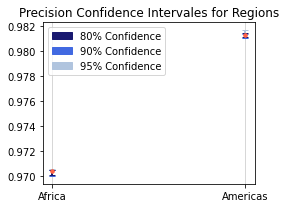

In [63]:
plt.figure(figsize=(4,3))
x = region_conf.category
y = region_conf.precision

# define precalculated error bars
p_lower_95 = region_conf['precision'] - region_conf['p_lower_95'] 
p_upper_95 = region_conf['p_upper_95'] - region_conf['precision'] 
p_lower_90 = region_conf['precision'] - region_conf['p_lower_90'] 
p_upper_90 = region_conf['p_upper_80'] - region_conf['precision'] 
p_lower_80 = region_conf['precision'] - region_conf['p_lower_80'] 
p_upper_80 = region_conf['p_upper_90'] - region_conf['precision'] 

plt.errorbar(x, y, yerr=[p_lower_95, p_upper_95], fmt='.', ecolor='lightsteelblue', elinewidth=2, markerfacecolor='tomato', markeredgecolor='tomato', capsize=3)
plt.errorbar(x, y, yerr=[p_lower_90, p_upper_90], fmt='.', ecolor='royalblue', elinewidth=2, markerfacecolor='tomato', markeredgecolor='tomato', capsize=3)
plt.errorbar(x, y, yerr=[p_lower_80, p_upper_80], fmt='.', ecolor='midnightblue', elinewidth=2, markerfacecolor='tomato', markeredgecolor='tomato', capsize=3)

plt.title("Precision Confidence Intervales for Regions")
plt.grid(axis='x', linestyle='-', linewidth=.5)

ci80 = mpatches.Patch(color='midnightblue', label='80% Confidence')
ci90 = mpatches.Patch(color='royalblue', label='90% Confidence')
ci95 = mpatches.Patch(color='lightsteelblue', label='95% Confidence')
plt.legend(handles=[ci80, ci90, ci95], loc='best')
plt.tight_layout();


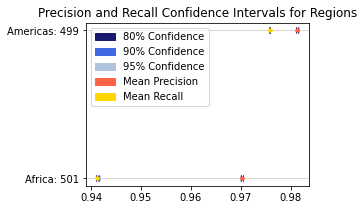

In [111]:
errorplot_precision_recall(region_conf, (4,3), 'Regions')

### Subregion

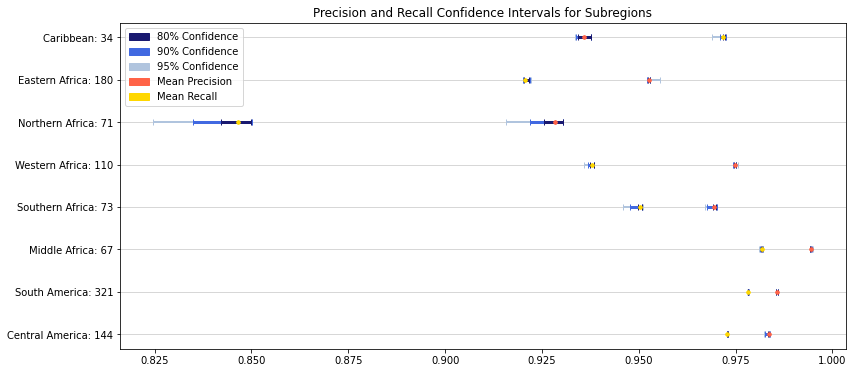

In [112]:
errorplot_precision_recall(subregion_conf, (13,6), 'Subregions')

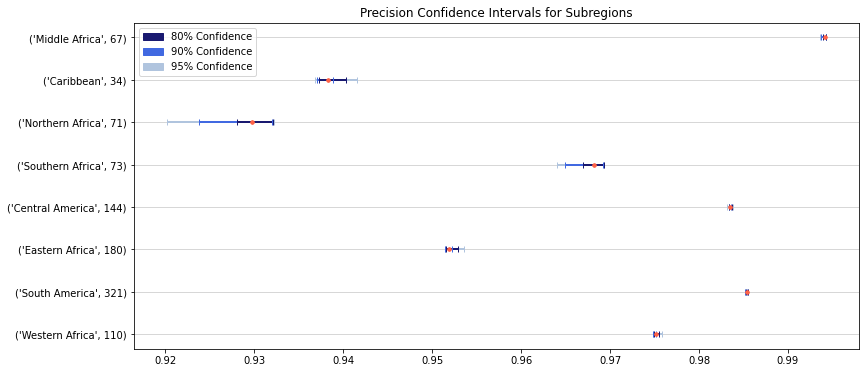

In [241]:
plt.figure(figsize=(13,6))

x = subregion_conf.precision
y = subregion_conf.category

# define precalculated error bars
p_lower_95 = subregion_conf['precision'] - subregion_conf['p_lower_95'] 
p_upper_95 = subregion_conf['p_upper_95'] - subregion_conf['precision'] 
p_lower_90 = subregion_conf['precision'] - subregion_conf['p_lower_90'] 
p_upper_90 = subregion_conf['p_upper_80'] - subregion_conf['precision'] 
p_lower_80 = subregion_conf['precision'] - subregion_conf['p_lower_80'] 
p_upper_80 = subregion_conf['p_upper_90'] - subregion_conf['precision'] 

plt.errorbar(x, y, xerr=[p_lower_95, p_upper_95], fmt='.', ecolor='lightsteelblue', elinewidth=2, markerfacecolor='tomato', markeredgecolor='tomato', capsize=3)
plt.errorbar(x, y, xerr=[p_lower_90, p_upper_90], fmt='.', ecolor='royalblue', elinewidth=2, markerfacecolor='tomato', markeredgecolor='tomato', capsize=3)
plt.errorbar(x, y, xerr=[p_lower_80, p_upper_80], fmt='.', ecolor='midnightblue', elinewidth=2, markerfacecolor='tomato', markeredgecolor='tomato', capsize=3)

plt.title("Precision Confidence Intervals for Subregions")
plt.grid(axis='y', linestyle='-', linewidth=.5)
plt.yticks(range(len(subregion_conf)), zip(subregion_conf.category, subregion_conf.num_samples))

ci80 = mpatches.Patch(color='midnightblue', label='80% Confidence')
ci90 = mpatches.Patch(color='royalblue', label='90% Confidence')
ci95 = mpatches.Patch(color='lightsteelblue', label='95% Confidence')
plt.legend(handles=[ci80, ci90, ci95], loc='best');

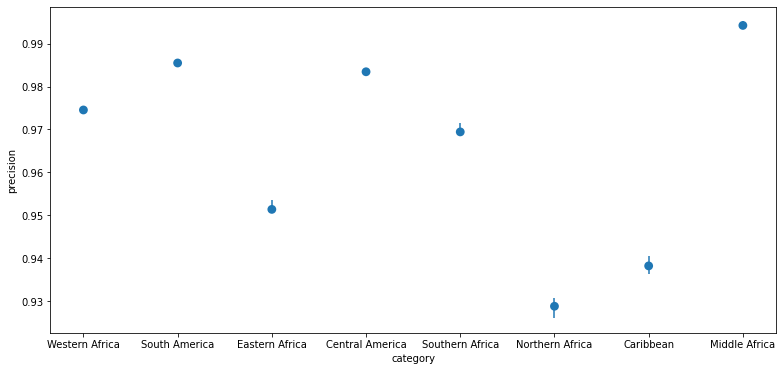

In [110]:
# https://stackoverflow.com/questions/43159528/error-bars-with-seaborn-and-stripplot
# https://matplotlib.org/devdocs/gallery/statistics/errorbar_features.html
plt.figure(figsize=(13,6))
ax = sns.pointplot(x=subregion_conf.category,  
                   y=subregion_conf.precision, 
                   data=subregion_conf,
                   join=False)

# Find the x,y coordinates for each point
x_coords = []
y_coords = []
for point_pair in ax.collections:
    for x, y in point_pair.get_offsets():
        x_coords.append(x)
        y_coords.append(y)

# Make sure the order is the same as the points were looped over
# define precalculated error bars
lower_error = subregion_conf['precision'] - subregion_conf['p_lower_95'] 
upper_error = subregion_conf['p_upper_95'] - subregion_conf['precision'] 
asymmetric_error = [lower_error, upper_error]
ax.errorbar(x_coords, y_coords, yerr=asymmetric_error, fmt=' ', zorder=-1);

### Biomes

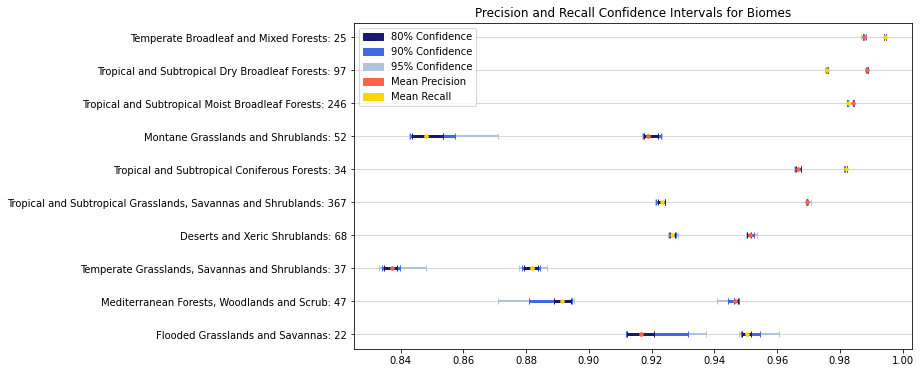

In [113]:
errorplot_precision_recall(biome_conf, (10,6), 'Biomes')

### Tree Class

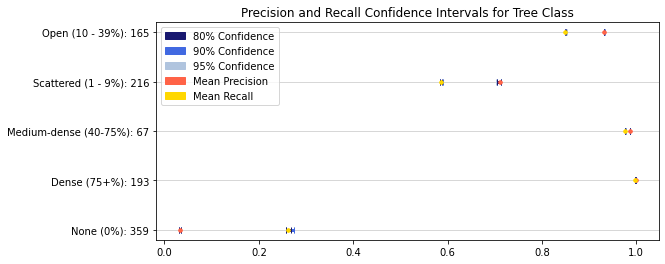

In [110]:
errorplot_precision_recall(treeclass_conf, (9,4), 'Tree Class')

### Ecoregion

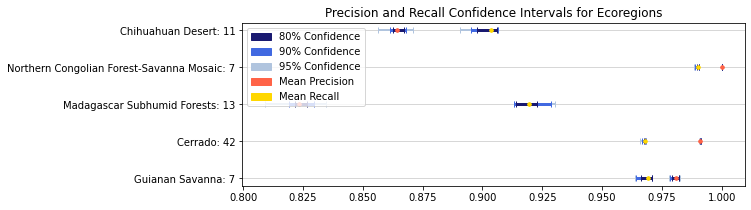

In [141]:
errorplot_precision_recall(ecoreg_conf[20:25], (9,3), 'Ecoregions')

### Country

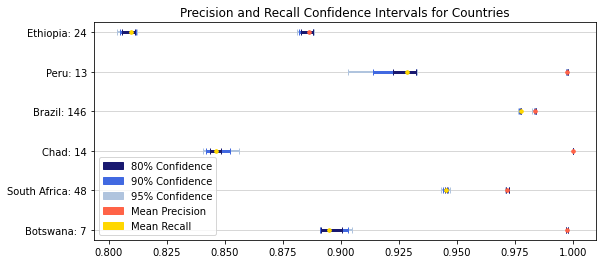

In [140]:
errorplot_precision_recall(country_conf[:6], (9,4), 'Countries')

## Visuals: Barplots

In [267]:
def visualize_precision_recall(conf_int_df, linewidth, figsize, title, subplots):

    fig, ax = plt.subplots(subplots[0], subplots[1], figsize=figsize, sharey=True, sharex=True)

# create precision plot
    ax1 = ax[0]
    ax1.set(title=f'Precision Confidence Intervals for {title}')
    ax1.tick_params(labelsize=12)
    
    # plot 95% CI
    for lower, upper, y in zip(conf_int_df['p_lower_90'],
                               conf_int_df['p_upper_90'],
                               range(len(conf_int_df))):

        ax1.plot((lower, upper), (y, y), color='lightsteelblue', linestyle='-', linewidth=linewidth*3)
    
    # plot 90% CI
    for lower, upper, y in zip(conf_int_df['p_lower_90'],
                               conf_int_df['p_upper_90'],
                               range(len(conf_int_df))):

        ax1.plot((lower, upper), (y, y), color='royalblue', linestyle='-', linewidth=linewidth*2)
        
    # plot 80% CI
    for lower, upper, y in zip(conf_int_df['p_lower_80'],
                               conf_int_df['p_upper_80'],
                               range(len(conf_int_df))):

        ax1.plot((lower, upper), (y, y), color='tomato', linestyle='-', linewidth=linewidth)
        
# create recall plot
    ax2 = ax[1]
    ax2.set(title=f'Recall Confidence Intervals for {title}')
    ax2.tick_params(labelsize=12)
    
    # plot 95% CI
    for lower, upper, y in zip(conf_int_df['r_lower_90'],
                               conf_int_df['r_upper_90'],
                               range(len(conf_int_df))):

        ax2.plot((lower, upper), (y, y), color='lightsteelblue', linestyle='-', linewidth=linewidth*3)
    
    # plot 90% CI
    for lower, upper, y in zip(conf_int_df['r_lower_90'],
                               conf_int_df['r_upper_90'],
                               range(len(conf_int_df))):

        ax2.plot((lower, upper), (y, y), color='royalblue', linestyle='-', linewidth=linewidth*2)
        
    # plot 80% CI
    for lower, upper, y in zip(conf_int_df['r_lower_80'],
                               conf_int_df['r_upper_80'],
                               range(len(conf_int_df))):

        ax2.plot((lower, upper), (y, y), color='tomato', linestyle='-', linewidth=linewidth)
    
    # add labels and legend
    ci80 = mpatches.Patch(color='tomato', label='80% Confidence')
    ci90 = mpatches.Patch(color='royalblue', label='90% Confidence')
    ci95 = mpatches.Patch(color='lightsteelblue', label='95% Confidence')
    plt.legend(handles=[ci80, ci90, ci95], loc='best')
    plt.yticks(range(len(conf_int_df)), list(conf_int_df['category']))
    plt.tight_layout();
    
    return None

In [174]:
def visualize_f1(conf_int_df, linewidth, figsize, title, ax=None):

    plt.figure(figsize = figsize)

    # plot 95% CI
    for lower, upper, y in zip(conf_int_df['f1_lower_90'],
                               conf_int_df['f1_upper_90'],
                               range(len(conf_int_df))):

        plt.plot((lower, upper), (y, y), color = 'thistle', linestyle='-', linewidth = linewidth*3)
    
    # plot 90% CI
    for lower, upper, y in zip(conf_int_df['f1_lower_90'],
                               conf_int_df['f1_upper_90'],
                               range(len(conf_int_df))):

        plt.plot((lower, upper), (y, y), color = 'darkslateblue', linestyle='-', linewidth = linewidth*2)
        
    # plot 80% CI
    for lower, upper, y in zip(conf_int_df['f1_lower_80'],
                               conf_int_df['f1_upper_80'],
                               range(len(conf_int_df))):

        plt.plot((lower, upper), (y, y), color = 'tomato', linestyle='-', linewidth = linewidth)

    plt.yticks(range(len(conf_int_df)), list(conf_int_df['category']))
    plt.title(f'F1 Confidence Intervals for {title}')
    
    return None

In [242]:
def visualize_precision(conf_int_df, linewidth, figsize, title):

    plt.figure(figsize = figsize)

    # plot 95% CI
    for lower, upper, y in zip(conf_int_df['p_lower_90'],
                               conf_int_df['p_upper_90'],
                               range(len(conf_int_df))):

        plt.plot((lower, upper), (y, y), color='lightsteelblue', linestyle='-', linewidth=linewidth*3)
    
    # plot 90% CI
    for lower, upper, y in zip(conf_int_df['p_lower_90'],
                               conf_int_df['p_upper_90'],
                               range(len(conf_int_df))):

        plt.plot((lower, upper), (y, y), color='royalblue', linestyle='-', linewidth=linewidth*2)
        
    # plot 80% CI
    for lower, upper, y in zip(conf_int_df['p_lower_80'],
                               conf_int_df['p_upper_80'],
                               range(len(conf_int_df))):

        plt.plot((lower, upper), (y, y), color='tomato', linestyle='-', linewidth=linewidth)

    plt.yticks(range(len(conf_int_df)), list(conf_int_df['category']))
    plt.title(f'Precision Confidence Intervals for {title}')
    
    return None

In [243]:
def visualize_recall(conf_int_df, linewidth, figsize, title):

    plt.figure(figsize = figsize)

    # plot 95% CI
    for lower, upper, y in zip(conf_int_df['r_lower_90'],
                               conf_int_df['r_upper_90'],
                               range(len(conf_int_df))):

        plt.plot((lower, upper), (y, y), color='lightsteelblue', linestyle='-', linewidth=linewidth*3)
    
    # plot 90% CI
    for lower, upper, y in zip(conf_int_df['r_lower_90'],
                               conf_int_df['r_upper_90'],
                               range(len(conf_int_df))):

        plt.plot((lower, upper), (y, y), color='royalblue', linestyle='-', linewidth=linewidth*2)
        
    # plot 80% CI
    for lower, upper, y in zip(conf_int_df['r_lower_80'],
                               conf_int_df['r_upper_80'],
                               range(len(conf_int_df))):

        plt.plot((lower, upper), (y, y), color='tomato', linestyle='-', linewidth=linewidth)

    plt.yticks(range(len(conf_int_df)), list(conf_int_df['category']))
    plt.title(f'Recall Confidence Intervals for {title}')
    
    return None

### Region

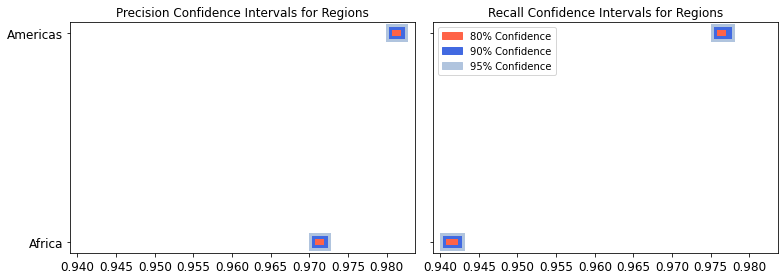

In [275]:
visualize_precision_recall(region_conf, 6, (11,4), 'Regions', [1,2])

### Subregion

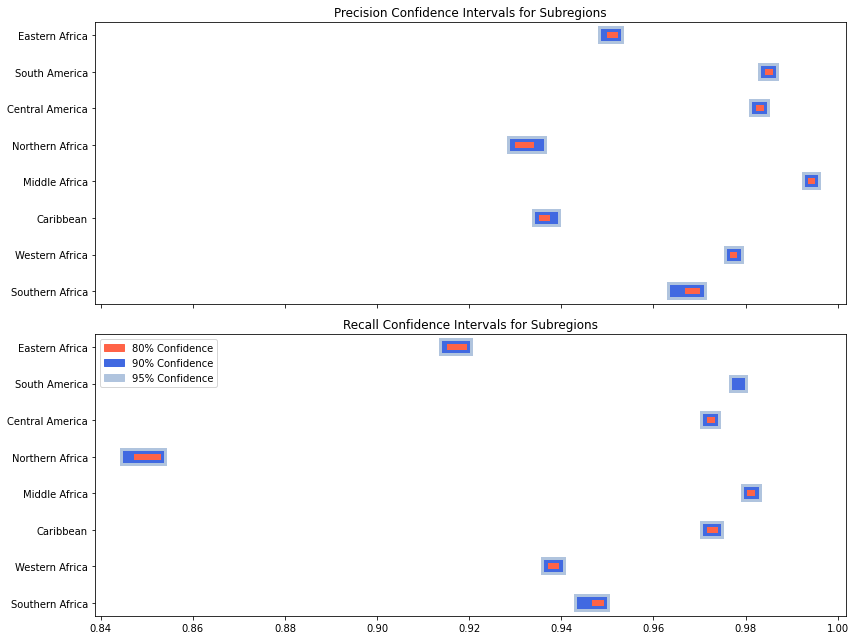

In [262]:
visualize_precision_recall(subregion_conf, 6, (12,9), 'Subregions', [2,1])

### Biome

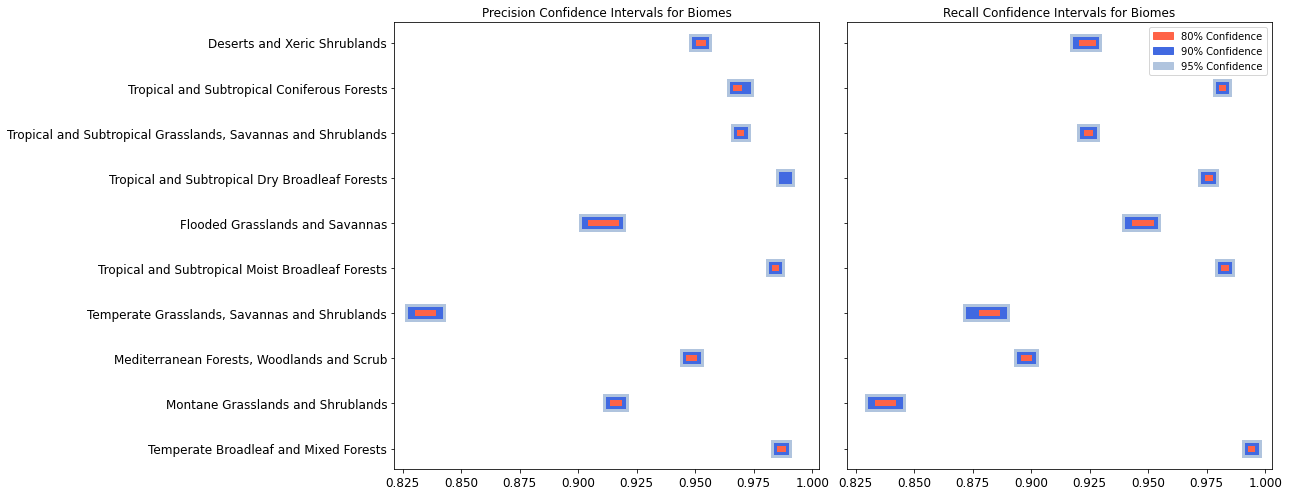

In [268]:
visualize_precision_recall(biome_conf, 6, (18,7), 'Biomes', [1,2])

#### Biomes (Africa)

In [223]:
africa = df[df.region == 'Africa']
africa.shape

(499, 16)

In [184]:
africa_val, africa_conf = bootstrap(africa, 'biome', 1000)

biome has 8 subcategories. 8000 samples in total.


/Users/jessicaertel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in long_scalars
  # This is added back by InteractiveShellApp.init_path()
/Users/jessicaertel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


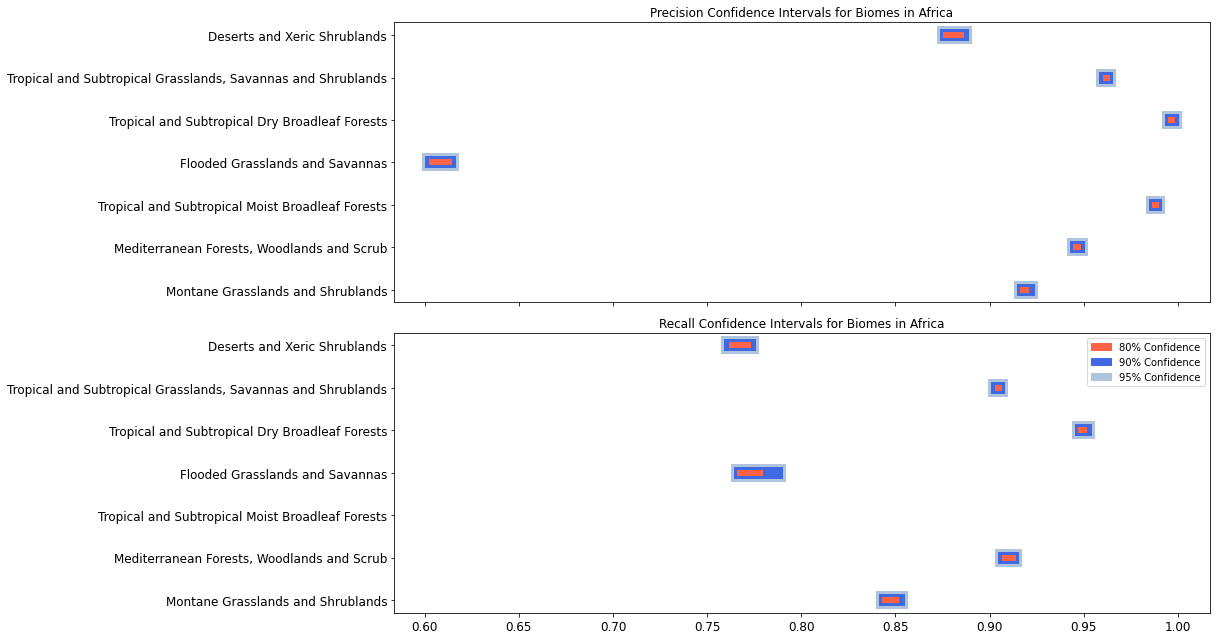

In [298]:
visualize_precision_recall(africa_conf.dropna(axis=0), 6, (17,9), 'Biomes in Africa', [2,1])

#### Biomes (East Africa)

In [299]:
east_africa = df[df.subregion == 'Eastern Africa']
east_africa.shape

(180, 16)

In [246]:
east_africa_val, east_africa_conf = bootstrap(east_africa, 'biome', 1000)

biome has 6 subcategories. 6000 samples in total.


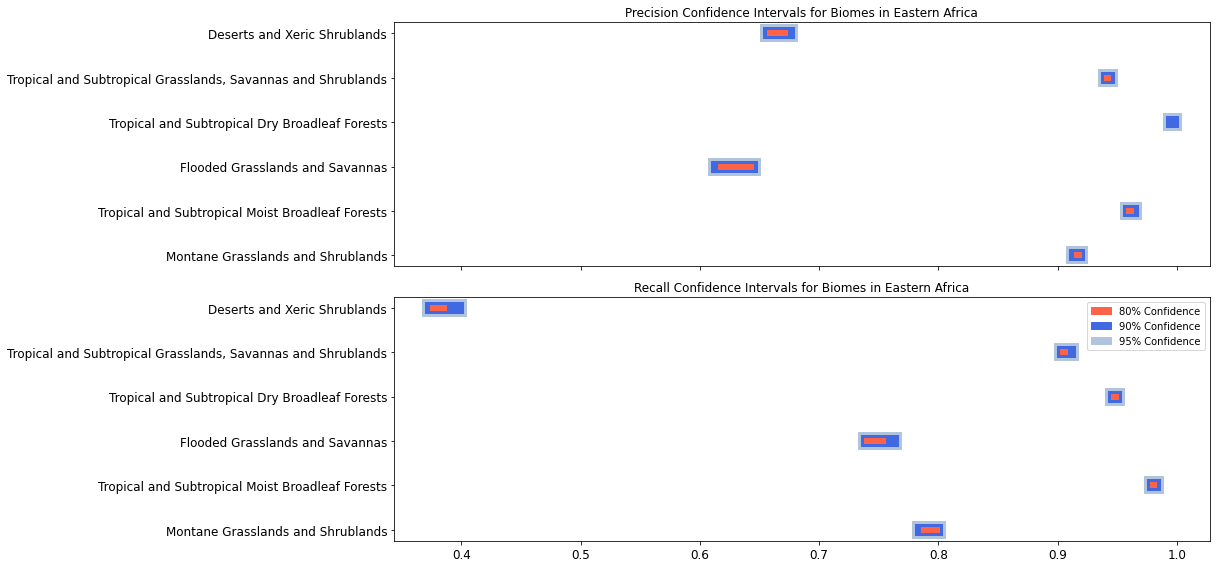

In [331]:
visualize_precision_recall(east_africa_conf.dropna(axis=0), 6, (17,8), 'Biomes in Eastern Africa', [2,1])

### Country

#### Countries in Eastern Africa

In [332]:
ea_countries = df[df.subregion == 'Eastern Africa']
ea_countries.shape

(180, 16)

In [334]:
ea_countries.country.value_counts()

Madagascar                     35
Ethiopia                       24
United Republic of Tanzania    23
Kenya                          18
Zimbabwe                       15
Zambia                         15
Mozambique                     13
Somalia                         8
Uganda                          8
South Sudan                     7
Malawi                          6
Somaliland                      3
Eritrea                         2
Rwanda                          2
Burundi                         1
Name: country, dtype: int64

In [335]:
ea_countries_val, ea_countries_conf = bootstrap(ea_countries, 'country', 1000)

country has 11 subcategories. 11000 samples in total.


/Users/jessicaertel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


In [338]:
ea_countries_conf

,scale,category,p_lower_95,p_upper_95,r_lower_95,r_upper_95,f1_lower_95,f1_upper_95,p_lower_90,p_upper_90,r_lower_90,r_upper_90,f1_lower_90,f1_upper_90,p_lower_80,p_upper_80,r_lower_80,r_upper_80,f1_lower_80,f1_upper_80
0,country,Zambia,0.939415,0.947446,0.982631,0.984896,0.961180,0.965323,0.943762,0.947265,0.982655,0.983909,0.963165,0.965128,0.944494,0.947094,0.982682,0.983672,0.963451,0.964944
1,country,Mozambique,0.907229,0.913435,0.922486,0.927642,0.915761,0.919827,0.908176,0.913216,0.923422,0.927330,0.916735,0.919229,0.908819,0.912964,0.924347,0.926931,0.917419,0.918900
2,country,Kenya,0.949709,0.954651,0.865933,0.881599,0.907170,0.915967,0.950099,0.954111,0.872561,0.881290,0.910321,0.915763,0.950456,0.953497,0.875480,0.880988,0.911700,0.915650
3,country,South Sudan,0.995825,0.996827,1.000000,1.000000,0.997908,0.998411,0.995959,0.996821,1.000000,1.000000,0.997975,0.998408,0.996223,0.996781,1.000000,1.000000,0.998108,0.998388
4,country,Uganda,0.892578,0.911135,0.916377,0.923723,0.904474,0.916549,0.897714,0.910318,0.919005,0.923215,0.908002,0.916063,0.905876,0.909854,0.919968,0.922828,0.913597,0.915842
5,country,Zimbabwe,0.903208,0.909285,0.914477,0.921337,0.908833,0.914945,0.903286,0.908606,0.914533,0.920603,0.908917,0.914249,0.903389,0.908111,0.914650,0.919804,0.909028,0.913820
6,country,Madagascar,0.981538,0.982892,0.965069,0.966462,0.973481,0.974395,0.981627,0.982846,0.965179,0.966214,0.973687,0.974319,0.981836,0.982800,0.965311,0.966074,0.973827,0.974279
7,country,Malawi,0.869734,0.898386,0.399320,0.428019,0.547599,0.580072,0.869937,0.891311,0.399591,0.423761,0.547756,0.574480,0.870131,0.876952,0.399951,0.413856,0.548053,0.561889
8,country,Somalia,0.000000,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN
9,country,United Republic of Tanzania,0.991512,0.992561,0.904271,0.912480,0.945885,0.950635,0.991548,0.992466,0.904800,0.910492,0.946170,0.949481,0.991625,0.991986,0.905298,0.910100,0.946500,0.949264


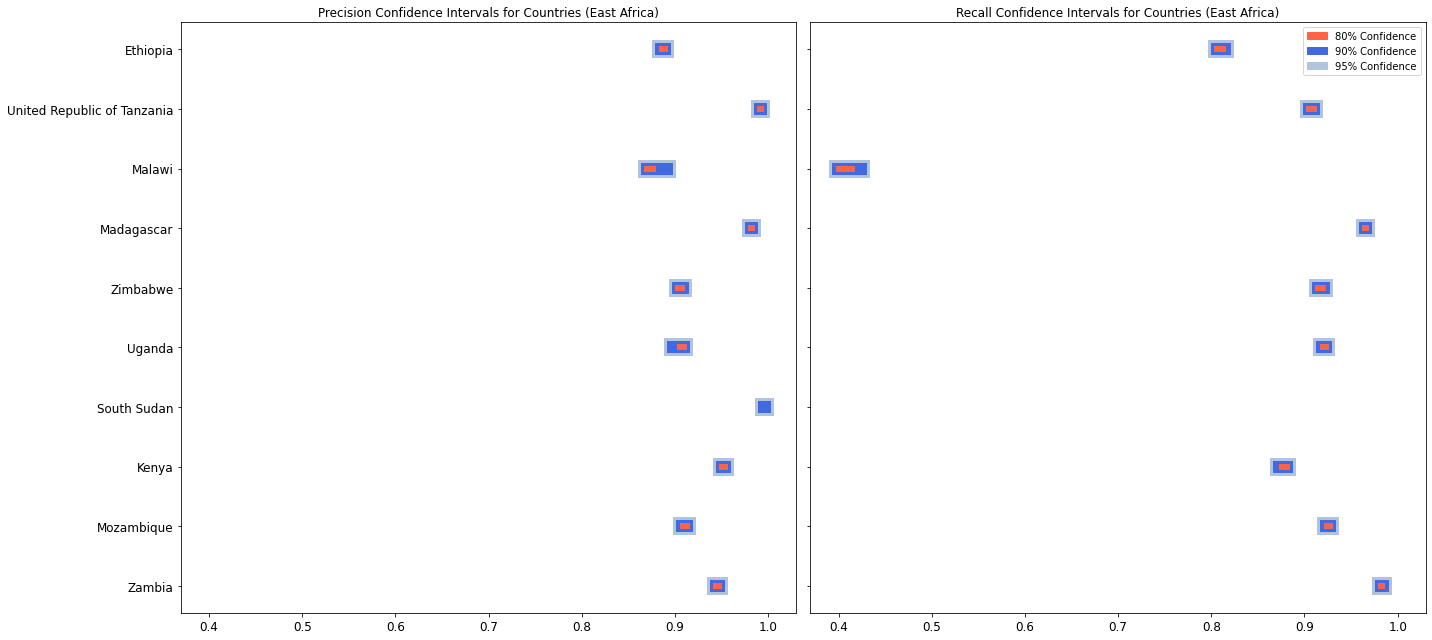

In [361]:
visualize_precision_recall(ea_countries_conf.dropna(axis=0), 6, (20,9), "Countries (East Africa)", [1,2])

## Visuals: Heatmap?
Expectation is to have a heatmap with biome by subregion
Mean of the precision would be hue and CI would be opacity. Less confident = darker and more opaque. More confident = brighter and less opaque.


In [206]:
biome_val.head()

,scale,category,precision,recall,f1
0,biome,Temperate Broadleaf and Mixed Forests,0.983633,1.000000,0.991749
1,biome,Temperate Broadleaf and Mixed Forests,0.976655,0.996597,0.986525
2,biome,Temperate Broadleaf and Mixed Forests,0.979599,0.994779,0.987130
3,biome,Temperate Broadleaf and Mixed Forests,0.979980,0.994482,0.987178
4,biome,Temperate Broadleaf and Mixed Forests,0.983841,0.992822,0.988311


In [207]:
subregion_val.head()

,scale,category,precision,recall,f1
0,subregion,Southern Africa,0.967645,0.932560,0.949778
1,subregion,Southern Africa,0.966603,0.917507,0.941416
2,subregion,Southern Africa,0.956439,0.922374,0.939098
3,subregion,Southern Africa,0.950470,0.916682,0.933270
4,subregion,Southern Africa,0.953409,0.925288,0.939138


In [ ]:
df_biome_subreg = pd.concat()

In [ ]:
# convert long form to tidy form
hm1 = pd.pivot_table(biome_val.precision.values)